<p style="background:#484E6E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> Lending Club</b><br>
    <br>Model 02 - Loan Grade Prediction<br>Model 03 - Loan Subgrade and Interest Rate Prediction<br><br> 
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 3: Unsupervised Learning & Hyperparameter Tuning<br>
Author : Renato Mariano</p>

<h1 style="color:#484E6E">Introduction </h1>

This data science project aims at automating lending decisions for LendingClub. It is a series of notebooks starting by 01_Data_Sampling_LendingClub.

<h2 style="color:#484E6E">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import gc
from rapidfuzz import process
import pydotplus
from IPython.display import Image

from scipy.sparse import issparse

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import CatBoostClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

from feature_engine.imputation import CategoricalImputer
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#C1524B">Feature Preprocessing</h1>

In [3]:
start = time()
df_train = pd.read_csv("data/exported/accepted_train.csv", skiprows=lambda x: x % 100)
end = time()
print(f"Read accepted train with pandas: {end-start:.3f}sec\n")
print(f"The shape of the data is: {df_train.shape}\n")
df_train.head(2)

Read accepted train with pandas: 3.650sec

The shape of the data is: (9042, 151)



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,137931428,NaN,15000.000,15000.000,15000.000,36 months,8.460,473.240,A,A5,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
1,117089741,NaN,6000.000,6000.000,6000.000,36 months,7.210,185.840,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


We start by creating our year column and dropping the rows where the amount requested is below 1000 USD.

We load our remaining columns and keep only them, drop the remaining NA values and check how much data we lost on that. As a result, we still kept about 88% of the training data.

In [4]:
df_train = df_train[df_train["loan_amnt"] >= 1000]

columns_remain = np.loadtxt("data/exported/accepted_columns.txt", dtype=str)
df_train = df_train[columns_remain]

df_train_reduced = df_train.dropna()
print(df_train_reduced.shape[0]/df_train.shape[0])

0.8735899137358991


<h2 style="color:#C1524B">Feature Engineering Pipeline</h2>

Our feature importance changed a lot in relation to our first model.

Here we will manually label encode the Employment Length, calculate a risk score.

In [5]:
class ApplyLabelToEmploymentLength():
    '''Change the values in employment length to highlight the natural order of this feature'''
    def __init__(self, column, mapping):
        self.column = column
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].map(self.mapping)
        return X      

class AverageFICO():
    '''Calculate the average of 'fico_range_low' and 'fico_range_high' columns and create a new column 'risk_score'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['fico_score'] = X[['fico_range_low', 'fico_range_high']].mean(axis=1)
        X = X.drop(['fico_range_low', 'fico_range_high'], axis=1)
        return X

class AverageLastFICO():
    '''Calculate the average of 'fico_range_low' and 'fico_range_high' columns and create a new column 'risk_score'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['last_fico_score'] = X[['last_fico_range_low', 'last_fico_range_high']].mean(axis=1)
        X = X.drop(['last_fico_range_low', 'last_fico_range_high'], axis=1)
        return X

class ApplyLabelToGrade():
    '''Change the values in grade or subgrade to integers'''
    def __init__(self, column, mapping):
        self.column = column
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].map(self.mapping)
        return X

In [6]:
empl_length_mapping = {
    "< 1 year": 0,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

grade_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

sub_grade_mapping = {
    "A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
    "B1": 12, "B2": 13, "B3": 14, "B4": 15, "B5": 16,
    "C1": 21, "C2": 22, "C3": 23, "C4": 24, "C5": 25,
    "D1": 31, "D2": 32, "D3": 33, "D4": 34, "D5": 35,
    "E1": 41, "E2": 42, "E3": 43, "E4": 44, "E5": 45,
    "F1": 51, "F2": 52, "F3": 53, "F4": 54, "F5": 55,
    "G1": 61, "G2": 62, "G3": 63, "G4": 64, "G5": 65,
}

# Add this transformer to your pipeline
feat_eng_pipe = Pipeline(
    steps=[
        ('map_empl_length', ApplyLabelToEmploymentLength(column="emp_length", mapping=empl_length_mapping)),
        ('average_fico', AverageFICO()),
        ('average_last_fico', AverageLastFICO()),
        ('map_grade', ApplyLabelToGrade(column="grade", mapping=grade_mapping)),
        ('map_subgrade', ApplyLabelToGrade(column="sub_grade", mapping=sub_grade_mapping)),
    ]
)

df_train_FeatEng = feat_eng_pipe.fit_transform(df_train_reduced)

In [7]:
df_train_FeatEng.head(6)

,acc_open_past_24mths,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,collection_recovery_fee,debt_settlement_flag,delinq_2yrs,delinq_amnt,disbursement_method,...,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,fico_score,last_fico_score
0,3.000,30000.000,Joint App,26287.000,8696.000,0.000,N,2.000,0.000,DirectPay,...,18432.000,5825.340,5825.340,551.500,0.000,5273.840,58657.000,Source Verified,697.000,732.000
1,1.000,85000.000,Individual,23788.000,25344.000,0.000,N,0.000,0.000,Cash,...,12000.000,3340.310,3340.310,501.880,0.000,2838.430,49000.000,Source Verified,692.000,777.000
2,5.000,130000.000,Individual,9638.000,3413.000,0.000,N,0.000,0.000,Cash,...,124013.000,8025.190,8025.190,1025.190,0.000,7000.000,28400.000,Verified,722.000,727.000
3,4.000,72000.000,Individual,17096.000,20329.000,0.000,N,0.000,0.000,Cash,...,34460.000,19070.723,19070.720,2070.720,0.000,17000.000,59800.000,Not Verified,777.000,827.000
4,7.000,55000.000,Individual,2252.000,2132.000,13.500,Y,0.000,0.000,Cash,...,23325.000,5636.280,5636.280,2591.600,0.000,2969.680,13600.000,Not Verified,677.000,557.000
5,6.000,50000.000,Individual,8168.000,485.000,0.000,N,0.000,0.000,Cash,...,43950.000,9655.261,9655.260,1655.260,0.000,8000.000,17300.000,Not Verified,717.000,737.000


<h2 style="color:#C1524B">Preprocessing Pipeline</h2>

We apply this pipeline for all the features but our targets. And we start moving towards building the Model to predict the loan grade

In [8]:
X_train = df_train_FeatEng.drop(['grade', 'int_rate', 'sub_grade'], axis=1)
y_train = df_train_FeatEng["grade"]
y_train_IntRate = df_train_FeatEng["int_rate"]

len(X_train.columns.values)

60

In [9]:
print(y_train_IntRate.shape, y_train.shape, X_train.shape)

(7899,) (7899,) (7899, 60)


In [10]:
del df_train, df_train_reduced
gc.collect()

1233

In [11]:
num_features = X_train.select_dtypes("number").columns
binary_features = X_train.select_dtypes("object").columns[X_train.select_dtypes("object").nunique() == 2]
cat_features = X_train.select_dtypes("object").columns[X_train.select_dtypes("object").nunique() > 2]

print(len(num_features) + len(binary_features) + len(cat_features))

60


This pipeline will be responsible for:
- RareEncoding followed by for the One-Hot-Encoding for the cat_features with higher cardinality (reduction of cardinality if still needed).
- SimpleEncoder for the binary_features. 
- RobustScaler for the continous features (outliers in the dataset).

In [12]:

num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ('robust_scaler', RobustScaler(with_centering=True, with_scaling=True)),
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("rare_encoder", RareLabelEncoder(tol=0.02, n_categories=1)),
        ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore')),
    ]
)

In [13]:
preprocess_pipe = ColumnTransformer(
   transformers=[
       ('numeric', num_transformer, num_features),
       ('binary', binary_transformer, binary_features),
       ('categorical', cat_transformer, cat_features),
    ],
    remainder='passthrough'
)

preprocess_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'collection_recovery_fee', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'emp_length', 'funded_amnt', 'funded_amnt_inv', 'inq_las...
       'initial_list_status', 'term'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('cat_mode_imputer',
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent')),
                                                 ('rare_encoder',
                                                  RareLabelEncoder(n_categories=1,
                                                                   tol=0.02)),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['home_ownership', 'loan_status', 'verification_status'], dtype='object'))])

To **keep track of the features** of our system and what our dataframe looks like, we will integrate to the pipeline a custom tranformation to merge the features names.

In [14]:
class ApplyColumnNamesTransformer():
    ''' Reaply features names to preprocessed array. '''
    def __init__(self, preprocess_pipe, cat_features, num_features, binary_features):
        self.preprocess_pipe = preprocess_pipe
        self.cat_features = cat_features
        self.num_features = num_features
        self.binary_features = binary_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if issparse(X):
            X = X.toarray()

        one_hot_feature_names = self.preprocess_pipe.transformers_[2][1].named_steps["one_hot_encoder"].get_feature_names_out(self.cat_features)
        all_feature_names = np.concatenate((self.num_features, self.binary_features, one_hot_feature_names))
        df_X = pd.DataFrame(X, columns=all_feature_names)
        
        return df_X

In [15]:
full_preprocess_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('apply_column_names', ApplyColumnNamesTransformer(preprocess_pipe, cat_features, num_features, binary_features))
])

In [16]:
full_preprocess_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'collection_recovery_fee', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'emp_length', 'funded_am...
                                                                   CategoricalImputer(ignore_format=True,
                                                                                      imputation_method='frequent')),
                                                                  ('rare_encoder',
                                                                   RareLabelEncoder(n_categories=1,
                                                                                    tol=0.02)),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['home_ownership', 'loan_status', 'verification_status'], dtype='object'))])),
                ('apply_column_names',
                 <__main__.ApplyColumnNamesTransformer object at 0x00000211106A93D0>)])

In [17]:
X_train_preprocess = full_preprocess_pipe.fit_transform(X_train)
X_train_preprocess.head()

,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,collection_recovery_fee,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,...,home_ownership_OWN,home_ownership_RENT,home_ownership_Rare,loan_status_Charged Off,loan_status_Current,loan_status_Fully Paid,loan_status_Rare,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,-0.250,-0.848,1.203,0.249,0.000,2.000,0.000,1.784,-0.750,0.077,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
1,-0.750,0.348,1.042,1.531,0.000,0.000,0.000,-0.699,0.375,-0.615,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
2,0.250,1.326,0.128,-0.158,0.000,0.000,0.000,0.295,-0.250,-0.538,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
3,0.000,0.065,0.610,1.145,0.000,0.000,0.000,-0.018,-0.125,0.231,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000
4,0.750,-0.304,-0.348,-0.257,13.500,0.000,0.000,0.836,0.000,-0.092,...,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000


In [18]:
X_train_preprocess.shape

(7899, 68)

Now that we have fully functioning pipelines, we can jump into the selection of models and hyperparameter tuning.

<h1 style="color:#C1524B">Grade Model</h1>

The following modeling solutions were defined. We start off by **setting the hyperparameters for the RandomSearch** for each of the defined models. The GridSearch is the responsible to find the best hyperparameters for each model while **it performs a cross-validation**. We used 5 cross-folds.

In [19]:
param_distributions = {
    'DecisionTree': {
        'model__max_depth': randint(2, 10),
        'model__min_samples_leaf': randint(30, 101)
    },
    'RandomForest': {
        'model__n_estimators': randint(10, 51),
        'model__max_depth': randint(2, 10),
        'model__min_samples_leaf': randint(15, 101)
    },
    'XGBoost': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(2, 10)
    },
    'CatBoost': {
        'model__iterations': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__depth': randint(2, 10)
    }
}

models = [
    ('DecisionTree', DecisionTreeClassifier(random_state=1)),
    ('RandomForest', RandomForestClassifier(random_state=1)),
    ('XGBoost', XGBClassifier(random_state=1)),
    ('CatBoost', CatBoostClassifier(random_state=1, verbose=False))
]


In [20]:
results = {}

# Iterate through the models and train them using randomized search
for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])

    param_dist = param_distributions.get(model_name, {})
    randomized_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_micro', random_state=1)
    randomized_search.fit(X_train_preprocess, y_train)

    results[model_name] = {
        'model': randomized_search.best_estimator_,
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_
    }

In [21]:
#results

In [22]:
print("Model F1-Scores:\n")
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

Model F1-Scores:

DecisionTree: 0.446
RandomForest: 0.48
XGBoost: 0.536
CatBoost: 0.493


Our model seems to perform very bad at this multiclassification problem. Let's limit even more our features, based on the top features obtained on the previous notebook.

In [23]:
feature_list = [
    "annual_inc",
    "loan_amnt",
    "funded_amnt",
    "funded_amnt_inv",
    "fico_score",
    "last_fico_score",
    "term",
    "total_rec_int",
    "disbursement_method",
    "bc_open_to_buy",
    "total_bc_limit",
    "total_rev_hi_lim",
    "emp_length"
]

X_train_limited = X_train_preprocess[feature_list]

In [24]:
results = {}

# Iterate through the models and train them using randomized search
for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])

    param_dist = param_distributions.get(model_name, {})
    randomized_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_micro', random_state=1)
    randomized_search.fit(X_train_limited, y_train)

    results[model_name] = {
        'model': randomized_search.best_estimator_,
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_
    }

In [25]:
print("Model F1-Scores:\n")
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

Model F1-Scores:

DecisionTree: 0.447
RandomForest: 0.477
XGBoost: 0.483
CatBoost: 0.482


This limiting the features seemed to only very slightly change the prediction power of the models.

In face of these poor results and due to the fact that we already went through a cross-validation, we will simply verify some of the results.

In [26]:
dt_model = results['DecisionTree']['model'].named_steps['model']
rf_model = results['RandomForest']['model'].named_steps['model']
xgb_model = results['XGBoost']['model'].named_steps['model']
cat_model = results['CatBoost']['model'].named_steps['model']

y_dt = dt_model.predict(X_train_limited)
y_rf = rf_model.predict(X_train_limited)
y_xgb = xgb_model.predict(X_train_limited)
y_cat = cat_model.predict(X_train_limited)

# predict probabilities
probs_dt = dt_model.predict_proba(X_train_limited)[:, 1]
probs_rf = rf_model.predict_proba(X_train_limited)[:, 1]
probs_xgb = xgb_model.predict_proba(X_train_limited)[:, 1]
probs_cat = cat_model.predict_proba(X_train_limited)[:, 1]

Let's evaluate these models first based on their f1-score and recall and then jump to the confusion matrices.

In [27]:
models = {
    'DecisionTree': (y_dt, probs_dt),
    'RandomForest': (y_rf, probs_rf),
    'XGBoost': (y_xgb, probs_xgb),
    'CatBoost': (y_cat, probs_cat),
}

for model_name, y_pred in models.items():
    f1 = f1_score(y_train, y_pred[0], average='micro')
    recall = recall_score(y_train, y_pred[0], average='micro')
    
    print(f"{model_name}")
    print(f"F1-Score: {f1:.3f} ; Recall: {recall:.3f}\n")

DecisionTree
F1-Score: 0.486 ; Recall: 0.486

RandomForest
F1-Score: 0.548 ; Recall: 0.548

XGBoost
F1-Score: 0.637 ; Recall: 0.637

CatBoost
F1-Score: 0.512 ; Recall: 0.512



When considering the whole training data, the score for the catboost seem to be better.

Let's see the results in a **confusion matrix**. The values exposed there are normalized and represent percentages in relation to true values.

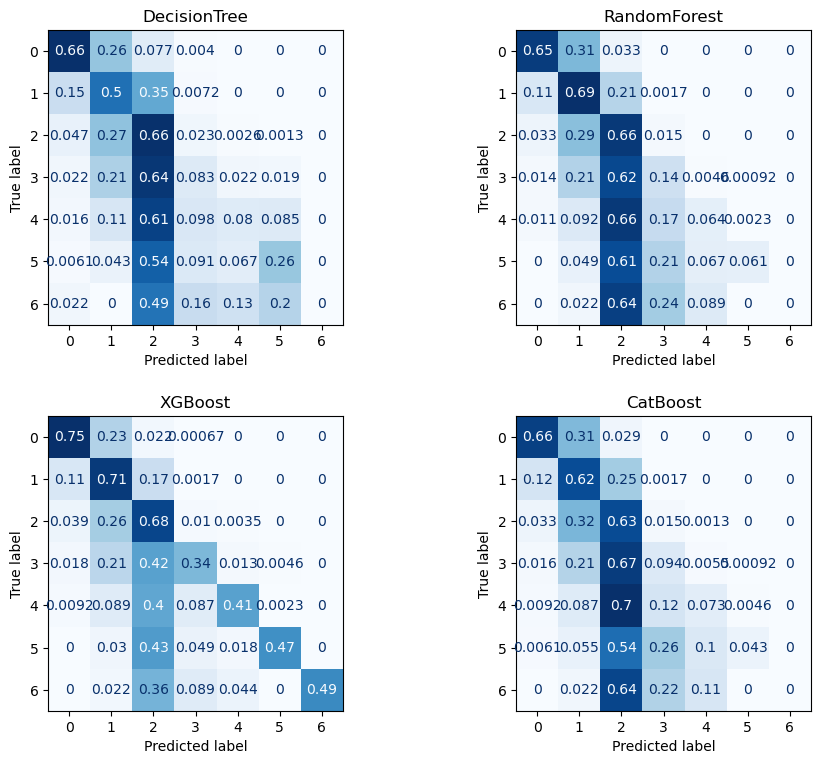

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models.keys(), models.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_pred[0], normalize='true',
                                                                  cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(f"{model_name}")

plt.tight_layout(pad=2)

As we see, most of the models fail to predict classes 3,4,5,6, or get only poor results as they try to classify in those classes.
XGBoost is the only which can predict some values correctly to class 6.

<h1 style="color:#C1524B">Interest Rate Model</h1>

Let's merge the grade back to the features and get our target variable.

In [29]:
X_train_IntRate = df_train_FeatEng.drop(['int_rate', 'sub_grade', 'grade'], axis=1)
X_train_IntRate = full_preprocess_pipe.fit_transform(X_train_IntRate)

y_train_IntRate = df_train_FeatEng["int_rate"]

In [30]:
X_train_preprocess.merge(df_train_FeatEng['grade'], right_index=True, left_index=True)


,acc_open_past_24mths,annual_inc,avg_cur_bal,bc_open_to_buy,collection_recovery_fee,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,...,home_ownership_RENT,home_ownership_Rare,loan_status_Charged Off,loan_status_Current,loan_status_Fully Paid,loan_status_Rare,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,grade
0,-0.250,-0.848,1.203,0.249,0.000,2.000,0.000,1.784,-0.750,0.077,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0
1,-0.750,0.348,1.042,1.531,0.000,0.000,0.000,-0.699,0.375,-0.615,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0
2,0.250,1.326,0.128,-0.158,0.000,0.000,0.000,0.295,-0.250,-0.538,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1
3,0.000,0.065,0.610,1.145,0.000,0.000,0.000,-0.018,-0.125,0.231,...,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0
4,0.750,-0.304,-0.348,-0.257,13.500,0.000,0.000,0.836,0.000,-0.092,...,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7893,-0.750,-0.743,-0.182,-0.410,0.000,0.000,0.000,0.553,-0.625,-0.646,...,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,2
7895,0.000,-0.087,0.058,0.190,0.000,0.000,0.000,0.157,-0.125,0.462,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1
7896,-0.500,0.117,-0.122,-0.065,0.000,0.000,0.000,1.323,0.000,0.248,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1
7897,-0.500,-0.565,3.459,-0.407,266.575,0.000,0.000,-0.919,0.500,0.212,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,2


In [31]:
X_train_IntRate = X_train_preprocess.merge(X_train, right_index=True, left_index=True)
print(X_train_IntRate.shape)
y_train_IntRate.shape

(6899, 128)


(7899,)

The way that the pipeline was build made the merging back of the grade reduce some rows that somehow did not match the index.

A change in the pipeline is required, so that this model can be carried out. We expect however better results from this regression model, since the loan grade works as surrogate to assign these values.

<h1 style="color:#C1524B">Conclusion - Loan Grades</h1>

The work on trying to predict these loan grades highlighted the importance of understanding the bussiness and understanding what parameters are predictors for a target.

Here, the dataframe had too many features and without understanding the business we can only base our choices on what the data tells us. Maybe some important feature for this prediction was removed in the previous steps, maybe some feature engineering should have been applied, but all of these choices would be better made with business specific knowledge.

**Improvements points**:

There is a lot of room to improvement in this notebook, as I said before, a better understanding of the business is needed.
Besides, the pipeline should be improved so that we can run our regression model.
The model should be deployed on google cloud, in this case, because of the bad performance, my aim is not to deploy the Loan Grade model, but the Classifier in Accepted/Rejected.